In [231]:
# ============================================================================
# Travelers UMC 2025 - Baseline Version 2
# Optimal 3-Model Ensemble for Subrogation Prediction
# ============================================================================
# Install missing packages if needed
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully!")

# Check and install required packages
packages_to_check = {
    'imbalanced-learn': 'imblearn',
    'xgboost': 'xgboost',
    'lightgbm': 'lightgbm',
    'optuna': 'optuna'
}

for pip_name, import_name in packages_to_check.items():
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        print(f"{pip_name} installed successfully!")

# All Required Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data handling
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                            classification_report, precision_recall_curve, average_precision_score)

# Models
import xgboost as xgb
import lightgbm as lgb

# Imbalance handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# Probability calibration
from sklearn.calibration import CalibratedClassifierCV

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Feature selection improvements
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold

# Advanced feature engineering
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Additional models
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("All libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print("="*80)



All libraries imported successfully!
XGBoost version: 3.1.1


In [232]:
# ============================================================================
# STEP 1: Load Engineered Data
# ============================================================================
print("="*80)
print("LOADING ENGINEERED DATA")
print("="*80)

train_df = pd.read_csv('engineered_train.csv')
test_df = pd.read_csv('engineered_test.csv')
test_original = pd.read_csv('Data\\Testing_TriGuard.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Drop non-feature columns
cols_to_drop = ['claim_date', 'year_of_born', 'vehicle_made_year', 
                'gender', 'living_status', 'claim_day_of_week', 'accident_site',
                'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color',
                'accident_type', 'in_network_bodyshop', 'zip_group']

train_df = train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns], errors='ignore')
test_df = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns], errors='ignore')

# Separate features and target
X = train_df.drop(['subrogation'], axis=1, errors='ignore')
y = train_df['subrogation'].astype(int)
X_test = test_df.copy()

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Align columns between train and test
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Handle any remaining NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# ============================================================================
# OUTLIER CAPPING (IQR Method)
# ============================================================================
print("\n" + "="*80)
print("OUTLIER CAPPING (IQR Method)")
print("="*80)

def cap_outliers_iqr(df, factor=1.5):
    """Cap outliers using IQR method"""
    df_capped = df.copy()
    capped_count = 0
    
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            
            # Count outliers before capping
            outliers_before = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            
            # Cap outliers
            df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
            
            if outliers_before > 0:
                capped_count += outliers_before
    
    return df_capped, capped_count

X_capped, outliers_capped = cap_outliers_iqr(X, factor=1.5)
X_test_capped, outliers_capped_test = cap_outliers_iqr(X_test, factor=1.5)

print(f"Outliers capped in training data: {outliers_capped}")
print(f"Outliers capped in test data: {outliers_capped_test}")
print(f"Outlier capping complete - using capped features")

# Use capped features
X = X_capped
X_test = X_test_capped

# ============================================================================
# ADVANCED PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("ADVANCED PREPROCESSING")
print("="*80)

# 1. Better missing value imputation (use median for numeric columns)
print("\nStep 1: Improved missing value imputation (median for numeric)...")
from sklearn.impute import SimpleImputer
numeric_cols = X.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
X = X_imputed
X_test = X_test_imputed

# 2. Remove low variance features
print("\nStep 2: Removing low variance features...")
from sklearn.feature_selection import VarianceThreshold
variance_selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X_var_filtered = variance_selector.fit_transform(X)
X_test_var_filtered = variance_selector.transform(X_test)
low_var_features = X.columns[~variance_selector.get_support()].tolist()
if len(low_var_features) > 0:
    print(f"  Removed {len(low_var_features)} low variance features")
    X = pd.DataFrame(X_var_filtered, columns=X.columns[variance_selector.get_support()])
    X_test = pd.DataFrame(X_test_var_filtered, columns=X_test.columns[variance_selector.get_support()])

# 3. Remove highly correlated features
print("\nStep 3: Removing highly correlated features...")
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
if len(high_corr_features) > 0:
    print(f"  Removed {len(high_corr_features)} highly correlated features (>0.95)")
    X = X.drop(columns=high_corr_features)
    X_test = X_test.drop(columns=[col for col in high_corr_features if col in X_test.columns])

print(f"\nAfter preprocessing: {X.shape[1]} features remaining")

print(f"\nFinal feature count: {X.shape[1]}")
print(f"Train samples: {X.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nClass distribution:\n{y.value_counts(normalize=True)}")


LOADING ENGINEERED DATA
Train shape: (18000, 105)
Test shape: (12000, 104)

OUTLIER CAPPING (IQR Method)
Outliers capped in training data: 43584
Outliers capped in test data: 47905
Outlier capping complete - using capped features

ADVANCED PREPROCESSING

Step 1: Improved missing value imputation (median for numeric)...

Step 2: Removing low variance features...
  Removed 24 low variance features

Step 3: Removing highly correlated features...
  Removed 16 highly correlated features (>0.95)

After preprocessing: 50 features remaining

Final feature count: 50
Train samples: 18000
Test samples: 12000

Class distribution:
subrogation
0    0.771389
1    0.228611
Name: proportion, dtype: float64


In [233]:
# ============================================================================
# STEP 2: Skip SMOTE (Testing without oversampling)
# ============================================================================
print("\n" + "="*80)
print("SKIPPING SMOTE - USING ORIGINAL UNBALANCED DATA")
print("="*80)

# NO SMOTE - Use original unbalanced data
# NOTE: X will be feature-engineered in Cell 3, and X_resampled will be updated there
# For now, just set resampled to original (they're the same since we skip SMOTE)
# We'll update X_resampled in Cell 3 after feature engineering
X_resampled = X.copy()
y_resampled = y.copy()

print(f"\nUsing original data: {X.shape[0]} samples")
print(f"Class distribution:\n{pd.Series(y_resampled).value_counts(normalize=True)}")
print(f"Class counts:\n{pd.Series(y_resampled).value_counts()}")

best_smote_strategy = None



SKIPPING SMOTE - USING ORIGINAL UNBALANCED DATA

Using original data: 18000 samples
Class distribution:
subrogation
0    0.771389
1    0.228611
Name: proportion, dtype: float64
Class counts:
subrogation
0    13885
1     4115
Name: count, dtype: int64


In [234]:
# ============================================================================
# STEP 3: Advanced Feature Engineering + Feature Selection
# ============================================================================
print("\n" + "="*80)
print("ADVANCED FEATURE ENGINEERING + FEATURE SELECTION")
print("="*80)

# Hardcode base feature count
best_feature_count = 80

# ============================================================================
# ADVANCED FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("CREATING ADVANCED FEATURES")
print("="*80)

from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, RobustScaler
from sklearn.cluster import KMeans
from scipy.interpolate import UnivariateSpline
from sklearn.decomposition import PCA

# Get top features for polynomial interactions (using current X before resampling)
selector_temp = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                  random_state=42, eval_metric='logloss', tree_method='hist')
selector_temp.fit(X, y)
importances = selector_temp.feature_importances_
top_10_features = X.columns[np.argsort(importances)[-10:]].tolist()
print(f"  Top 10 features for engineering: {top_10_features[:5]}...")

print("\nStep 1: Creating polynomial features (degree 3) for top 10 features...")
poly_features = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
# Only apply to top features to avoid explosion
X_poly = pd.DataFrame(poly_features.fit_transform(X[top_10_features]), 
                      columns=[f'poly_{i}' for i in range(poly_features.n_output_features_)])
X_test_poly = pd.DataFrame(poly_features.transform(X_test[top_10_features]),
                           columns=[f'poly_{i}' for i in range(poly_features.n_output_features_)])

# Select top polynomial features by correlation with target
poly_corrs = [abs(pd.Series(X_poly.iloc[:, i]).corr(pd.Series(y))) for i in range(X_poly.shape[1])]
top_poly_indices = np.argsort(poly_corrs)[-20:]  # Top 20 polynomial features
X_poly_selected = X_poly.iloc[:, top_poly_indices]
X_test_poly_selected = X_test_poly.iloc[:, top_poly_indices]
print(f"  Created {len(top_poly_indices)} polynomial features")

print("\nStep 2: Creating clustering-based features...")
# Cluster samples based on top features
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels_train = kmeans.fit_predict(X[top_10_features])
cluster_labels_test = kmeans.predict(X_test[top_10_features])

# Add cluster features
X['cluster_id'] = cluster_labels_train
X_test['cluster_id'] = cluster_labels_test
# One-hot encode clusters
for i in range(n_clusters):
    X[f'cluster_{i}'] = (X['cluster_id'] == i).astype(int)
    X_test[f'cluster_{i}'] = (X_test['cluster_id'] == i).astype(int)
print(f"  Created {n_clusters} cluster membership features")

print("\nStep 3: Creating binned features for continuous variables...")
# Bin top 5 continuous features
top_continuous = [col for col in top_10_features if X[col].dtype in [np.float64, np.int64]][:5]
if len(top_continuous) > 0:
    binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', random_state=42)
    X_binned = pd.DataFrame(binner.fit_transform(X[top_continuous]),
                            columns=[f'{col}_binned' for col in top_continuous], index=X.index)
    X_test_binned = pd.DataFrame(binner.transform(X_test[top_continuous]),
                                 columns=[f'{col}_binned' for col in top_continuous], index=X_test.index)
    X = pd.concat([X, X_binned], axis=1)
    X_test = pd.concat([X_test, X_test_binned], axis=1)
    print(f"  Created {len(top_continuous)} binned features")

print("\nStep 4: Adding PCA features from correlated feature groups...")
# Find correlated groups and create PCA features
if X.shape[1] > 50:
    corr_groups = []
    processed = set()
    for col in X.columns:
        if col not in processed:
            corr_group = [col]
            for other_col in X.columns:
                if other_col != col and other_col not in processed:
                    if abs(X[[col, other_col]].corr().iloc[0, 1]) > 0.7:
                        corr_group.append(other_col)
                        processed.add(other_col)
            if len(corr_group) > 2:
                corr_groups.append(corr_group)
                processed.add(col)
    
    # Create PCA for each group
    pca_count = 0
    for group in corr_groups[:3]:  # Limit to 3 groups
        if len(group) > 2 and all(col in X.columns for col in group):
            pca = PCA(n_components=2, random_state=42)
            X_pca = pca.fit_transform(X[group])
            X_test_pca = pca.transform(X_test[group])
            for i in range(2):
                X[f'pca_group_{pca_count}_comp{i}'] = X_pca[:, i]
                X_test[f'pca_group_{pca_count}_comp{i}'] = X_test_pca[:, i]
            pca_count += 1
    print(f"  Created {pca_count * 2} PCA features")

# Combine all new features
X = pd.concat([X, X_poly_selected], axis=1)
X_test = pd.concat([X_test, X_test_poly_selected], axis=1)

# Align columns
X_test = X_test.reindex(columns=X.columns, fill_value=0)

print(f"\n✓ Total features after engineering: {X.shape[1]}")

# Update X_resampled to match X after feature engineering
X_resampled = X.copy()
y_resampled = y.copy()

# ============================================================================
# FEATURE SELECTION
# ============================================================================
print(f"\nSelecting top {best_feature_count} features from {X.shape[1]} total...")

# Apply best feature selection
selector_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1,
    random_state=42, 
    eval_metric='logloss',
    tree_method='hist'
)
selector_model.fit(X_resampled, y_resampled)

# Also compute mutual information for better feature selection
print("\nComputing mutual information scores...")
mi_scores = mutual_info_classif(X_resampled, y_resampled, random_state=42, n_neighbors=5)
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# Combine tree importance and mutual information
importances = selector_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'tree_importance': importances,
    'mi_score': mi_scores
})
# Normalize and combine
feature_importance_df['tree_importance_norm'] = (feature_importance_df['tree_importance'] - 
                                                  feature_importance_df['tree_importance'].min()) / \
                                                 (feature_importance_df['tree_importance'].max() - 
                                                  feature_importance_df['tree_importance'].min() + 1e-10)
feature_importance_df['mi_score_norm'] = (feature_importance_df['mi_score'] - 
                                          feature_importance_df['mi_score'].min()) / \
                                         (feature_importance_df['mi_score'].max() - 
                                          feature_importance_df['mi_score'].min() + 1e-10)
feature_importance_df['combined_score'] = (feature_importance_df['tree_importance_norm'] * 0.7 + 
                                           feature_importance_df['mi_score_norm'] * 0.3)
feature_importance_df = feature_importance_df.sort_values('combined_score', ascending=False)

# Select top features based on combined score
top_n = min(best_feature_count, len(X.columns))
top_features = feature_importance_df.head(top_n)['feature'].tolist()

# Use SelectFromModel with the best feature count
selector = SelectFromModel(selector_model, max_features=top_n, threshold=-np.inf)
# Transform X (before resampling), then resample will be done separately
X_selected = selector.fit_transform(X, y)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()].tolist()
print(f"\nSelected {len(selected_features)} features from {X.shape[1]} total features")
print(f"\nTop 20 features (by combined score): {top_features[:20]}")

# ============================================================================
# FEATURE COUNT VARIATIONS (Test 70/80/90 features)
# ============================================================================
print("\n" + "="*80)
print("TESTING FEATURE COUNT VARIATIONS (70/80/90)")
print("="*80)

# Get actual number of available features
n_available_features = X.shape[1]
print(f"Available features: {n_available_features}")

# Cap feature counts to available features
feature_counts_to_test = [f for f in [70, 80, 90] if f <= n_available_features]
if len(feature_counts_to_test) == 0:
    # If all requested counts exceed available, test the maximum available
    feature_counts_to_test = [min(80, n_available_features)]
    print(f"All requested counts exceed available features. Testing {feature_counts_to_test[0]} features instead.")

best_feature_count_score = {}
max_test_features = min(max(feature_counts_to_test), n_available_features)
temp_selector = SelectFromModel(selector_model, max_features=max_test_features, threshold=-np.inf)
X_temp_selected_all = temp_selector.fit_transform(X, y)

for n_features in feature_counts_to_test:
    # Ensure we don't exceed available features
    n_features = min(n_features, n_available_features)
    
    # Get top n features
    top_n_temp = feature_importance_df.head(n_features)['feature'].tolist()
    
    # Quick evaluation on subset using SelectFromModel for exact feature selection
    temp_selector_n = SelectFromModel(selector_model, max_features=n_features, threshold=-np.inf)
    X_temp_selected_n = temp_selector_n.fit_transform(X, y)
    
    from sklearn.model_selection import train_test_split
    X_sub, _, y_sub, _ = train_test_split(X_temp_selected_n, y, 
                                            test_size=0.85, random_state=42, stratify=y)
    # Exclude n_estimators and random_state from params, then add them back with specific values
    temp_params = {k: v for k, v in best_xgb_params.items() 
                   if k not in ['n_estimators', 'random_state']}
    temp_params['n_estimators'] = 50
    temp_params['random_state'] = 42
    temp_params['tree_method'] = 'hist'
    temp_model = xgb.XGBClassifier(**temp_params)
    temp_model.fit(X_sub, y_sub)
    temp_pred = temp_model.predict_proba(X_sub)[:, 1]
    temp_f1 = f1_score(y_sub, (temp_pred >= 0.4).astype(int))
    best_feature_count_score[n_features] = temp_f1
    print(f"  {n_features} features: F1 = {temp_f1:.5f}")

if best_feature_count_score:
    best_feature_count = max(best_feature_count_score.items(), key=lambda x: x[1])[0]
    print(f"\n✓ Best feature count: {best_feature_count} (F1: {best_feature_count_score[best_feature_count]:.5f})")
    # Re-select with best count
    selector_final = SelectFromModel(selector_model, max_features=best_feature_count, threshold=-np.inf)
    X_selected = selector_final.fit_transform(X, y)
    X_test_selected = selector_final.transform(X_test)
    selected_features = X.columns[selector_final.get_support()].tolist()
    print(f"  Final selected: {len(selected_features)} features")



ADVANCED FEATURE ENGINEERING + FEATURE SELECTION

CREATING ADVANCED FEATURES
  Top 10 features for engineering: ['accident_site_enc_x_liab_prct', 'high_education_ind', 'in_network_bodyshop_enc', 'liab_prct', 'liab_prct_x_accident_type_enc']...

Step 1: Creating polynomial features (degree 3) for top 10 features...
  Created 20 polynomial features

Step 2: Creating clustering-based features...
  Created 5 cluster membership features

Step 3: Creating binned features for continuous variables...
  Created 5 binned features

Step 4: Adding PCA features from correlated feature groups...
  Created 4 PCA features

✓ Total features after engineering: 85

Selecting top 80 features from 85 total...

Computing mutual information scores...

Selected 80 features from 85 total features

Top 20 features (by combined score): ['cluster_2', 'pca_group_0_comp0', 'pca_group_0_comp1', 'poly_63', 'liab_prct_plus_accident_type_enc', 'poly_64', 'poly_9', 'poly_57', 'vehicle_weight', 'poly_61', 'poly_172', 'p

In [235]:
# ============================================================================
# STEP 4: Custom F1 Metric for Training
# ============================================================================
print("\n" + "="*80)
print("SETTING UP CUSTOM F1 METRIC FOR TRAINING")
print("="*80)

# Custom F1 metric for XGBoost (using callback approach)
def xgb_f1_eval(y_pred, dtrain):
    """Custom F1 evaluation metric for XGBoost via callback"""
    y_true = dtrain.get_label()
    y_pred_binary = (y_pred >= 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1', f1

# Custom F1 metric for LightGBM
def lgb_f1_eval(y_pred, y_true):
    """Custom F1 evaluation metric for LightGBM"""
    # y_true is already a numpy array in LightGBM
    y_pred_binary = (y_pred >= 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1', f1, True  # True means "higher is better"

print("✓ Custom F1 metrics defined for both XGBoost and LightGBM")

# ============================================================================
# COST-SENSITIVE LEARNING (Fine-tuning scale_pos_weight)
# ============================================================================
print("\n" + "="*80)
print("COST-SENSITIVE LEARNING - FINE-TUNING scale_pos_weight")
print("="*80)

# Fine-tune scale_pos_weight around current best for XGBoost and LightGBM
# This helps balance precision vs recall for better F1
scale_pos_weight_candidates = [1.5, 1.55, 1.6, 1.61, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9]

print(f"\nTesting scale_pos_weight values for fine-tuning (current XGB: {best_xgb_params.get('scale_pos_weight', 'not set')})")
print(f"Testing scale_pos_weight values for fine-tuning (current LGB: {best_lgb_params.get('scale_pos_weight', 'not set')})")

# Store original params
original_xgb_params = best_xgb_params.copy()
original_lgb_params = best_lgb_params.copy()

# Quick test on a subset to find best scale_pos_weight
print("\nQuick evaluation (using 10% sample for speed)...")
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(X_resampled, y_resampled, 
                                               test_size=0.9, random_state=42, stratify=y_resampled)

best_xgb_scale = best_xgb_params.get('scale_pos_weight', 1.61)
best_lgb_scale = best_lgb_params.get('scale_pos_weight', 1.61)

if 'scale_pos_weight' in best_xgb_params:
    # Test XGBoost scale_pos_weight
    xgb_scale_scores = {}
    for scale in scale_pos_weight_candidates:
        temp_params = original_xgb_params.copy()
        temp_params['scale_pos_weight'] = scale
        temp_model = xgb.XGBClassifier(**temp_params)
        temp_model.fit(X_sample, y_sample)
        temp_pred = temp_model.predict_proba(X_sample)[:, 1]
        temp_f1 = f1_score(y_sample, (temp_pred >= 0.4).astype(int))
        xgb_scale_scores[scale] = temp_f1
    
    best_xgb_scale = max(xgb_scale_scores.items(), key=lambda x: x[1])[0]
    print(f"  Best XGBoost scale_pos_weight: {best_xgb_scale:.2f} (F1: {xgb_scale_scores[best_xgb_scale]:.5f})")
    best_xgb_params['scale_pos_weight'] = best_xgb_scale

if 'scale_pos_weight' in best_lgb_params or 'class_weight' in best_lgb_params:
    # For LightGBM, we might use class_weight='balanced' instead
    # But if scale_pos_weight exists, fine-tune it
    if 'scale_pos_weight' in best_lgb_params:
        lgb_scale_scores = {}
        for scale in scale_pos_weight_candidates:
            temp_params = original_lgb_params.copy()
            temp_params['scale_pos_weight'] = scale
            temp_model = lgb.LGBMClassifier(**temp_params)
            temp_model.fit(X_sample, y_sample)
            temp_pred = temp_model.predict_proba(X_sample)[:, 1]
            temp_f1 = f1_score(y_sample, (temp_pred >= 0.4).astype(int))
            lgb_scale_scores[scale] = temp_f1
        
        best_lgb_scale = max(lgb_scale_scores.items(), key=lambda x: x[1])[0]
        print(f"  Best LightGBM scale_pos_weight: {best_lgb_scale:.2f} (F1: {lgb_scale_scores[best_lgb_scale]:.5f})")
        best_lgb_params['scale_pos_weight'] = best_lgb_scale

print("\n✓ Cost-sensitive learning fine-tuning complete")

# ============================================================================
# STEP 4b: Use Optimized Hyperparameters (Hardcoded from Optuna Results)
# ============================================================================
print("\n" + "="*80)
print("USING OPTIMIZED HYPERPARAMETERS (FROM UNBALANCED DATA OPTIMIZATION)")
print("="*80)

# Best XGBoost parameters (Trial 40, F1: 0.596028 on unbalanced data)
best_xgb_params = {
    'n_estimators': 522,
    'max_depth': 5,
    'learning_rate': 0.011305049467535003,
    'subsample': 0.7819029757940441,
    'colsample_bytree': 0.9825075171908686,
    'gamma': 0.9928333128488815,
    'min_child_weight': 6,
    'reg_alpha': 0.9207509543620025,
    'reg_lambda': 0.830740562660677,
    'scale_pos_weight': 1.611933210343247,
    'random_state': 42,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

# Best LightGBM parameters (Trial 11, F1: 0.594427 on unbalanced data)
best_lgb_params = {
    'n_estimators': 1188,
    'max_depth': 4,
    'learning_rate': 0.17363619306522782,
    'num_leaves': 35,
    'subsample': 0.802754798121327,
    'colsample_bytree': 0.9524354469089091,
    'reg_alpha': 0.8635266072922643,
    'reg_lambda': 2.996812217001195,
    'min_child_samples': 11,
    'class_weight': 'balanced',
    'random_state': 42,
    'verbose': -1
}

print("\nOptimized Hyperparameters Loaded:")
print(f"XGBoost F1: 0.59603 (Trial 40 - optimized on unbalanced data)")
print(f"LightGBM F1: 0.59443 (Trial 11 - optimized on unbalanced data)")
print("\n" + "="*80)



SETTING UP CUSTOM F1 METRIC FOR TRAINING
✓ Custom F1 metrics defined for both XGBoost and LightGBM

COST-SENSITIVE LEARNING - FINE-TUNING scale_pos_weight

Testing scale_pos_weight values for fine-tuning (current XGB: 1.611933210343247)
Testing scale_pos_weight values for fine-tuning (current LGB: not set)

Quick evaluation (using 10% sample for speed)...
  Best XGBoost scale_pos_weight: 1.60 (F1: 0.86534)

✓ Cost-sensitive learning fine-tuning complete

USING OPTIMIZED HYPERPARAMETERS (FROM UNBALANCED DATA OPTIMIZATION)

Optimized Hyperparameters Loaded:
XGBoost F1: 0.59603 (Trial 40 - optimized on unbalanced data)
LightGBM F1: 0.59443 (Trial 11 - optimized on unbalanced data)



In [236]:
# ============================================================================
# STEP 5: Train Base Models with Optimized Hyperparameters
# ============================================================================
print("\n" + "="*80)
print("TRAINING BASE MODELS")
print("="*80)

# Model 1: XGBoost with early stopping
print("\n[1/2] Training XGBoost with early stopping...")
# Split selected data for early stopping validation
from sklearn.model_selection import train_test_split
# Convert to numpy if needed
if isinstance(X_selected, pd.DataFrame):
    X_selected_array = X_selected.values
else:
    X_selected_array = X_selected
    
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_selected_array, y, test_size=0.2, random_state=42, stratify=y
)

xgb_model = xgb.XGBClassifier(**best_xgb_params)
# Note: XGBoost doesn't support custom eval_metric in fit() directly
# We'll monitor F1 externally, but training still uses the eval_metric from params (logloss)
xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)
xgb_preds_train = xgb_model.predict_proba(X_selected_array)[:, 1]
xgb_preds_test = xgb_model.predict_proba(X_test_selected)[:, 1]
xgb_f1 = f1_score(y_resampled, (xgb_preds_train >= 0.5).astype(int))
xgb_auc = roc_auc_score(y_resampled, xgb_preds_train)
print(f"XGBoost Train F1: {xgb_f1:.5f}, AUC: {xgb_auc:.5f}")

# Model 2: LightGBM with early stopping
print("\n[2/2] Training LightGBM with early stopping...")
lgb_model = lgb.LGBMClassifier(**best_lgb_params)
# Note: LightGBM sklearn wrapper has issues with custom eval_metric in fit()
# We'll rely on threshold optimization for F1, but still optimize during training
lgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
lgb_preds_train = lgb_model.predict_proba(X_selected_array)[:, 1]
lgb_preds_test = lgb_model.predict_proba(X_test_selected)[:, 1]
lgb_f1 = f1_score(y_resampled, (lgb_preds_train >= 0.5).astype(int))
lgb_auc = roc_auc_score(y_resampled, lgb_preds_train)
print(f"LightGBM Train F1: {lgb_f1:.5f}, AUC: {lgb_auc:.5f}")

print("\n" + "="*80)
print("BASE MODEL TRAINING COMPLETE")
print("="*80)



TRAINING BASE MODELS

[1/2] Training XGBoost with early stopping...
XGBoost Train F1: 0.62373, AUC: 0.87661

[2/2] Training LightGBM with early stopping...
LightGBM Train F1: 0.77452, AUC: 0.94940

BASE MODEL TRAINING COMPLETE


In [237]:
# ============================================================================
# STEP 6: Compare Models and Select Best
# ============================================================================
# NOTE: These scores are on training data with fixed threshold (0.5)
# These are NOT the final scores - see Cell 9 for real CV performance on unbalanced data
print("\n" + "="*80)
print("MODEL COMPARISON ON TRAINING DATA (Fixed threshold 0.5)")
print("="*80)
print(f"\nXGBoost: F1 = {xgb_f1:.5f}, AUC = {xgb_auc:.5f}")
print(f"LightGBM: F1 = {lgb_f1:.5f}, AUC = {lgb_auc:.5f}")
print("\n⚠️  NOTE: These are training scores. Real performance is in Cell 9 (CV on unbalanced data)")

if lgb_f1 > xgb_f1:
    best_model = "LightGBM"
    best_preds_test = lgb_preds_test
    best_model_obj = lgb_model
    print(f"\n✓ Best Model: LightGBM (F1: {lgb_f1:.5f})")
else:
    best_model = "XGBoost"
    best_preds_test = xgb_preds_test
    best_model_obj = xgb_model
    print(f"\n✓ Best Model: XGBoost (F1: {xgb_f1:.5f})")
print("="*80)



MODEL COMPARISON ON TRAINING DATA (Fixed threshold 0.5)

XGBoost: F1 = 0.62373, AUC = 0.87661
LightGBM: F1 = 0.77452, AUC = 0.94940

⚠️  NOTE: These are training scores. Real performance is in Cell 9 (CV on unbalanced data)

✓ Best Model: LightGBM (F1: 0.77452)


In [238]:
# This cell has been removed - no ensemble code needed


In [239]:
# This cell has been removed - no ensemble code needed


In [ ]:
# ============================================================================
# STEP 9: Cross-Validation Evaluation on Original Unbalanced Data
# ============================================================================
print("\n" + "="*80)
print("CROSS-VALIDATION EVALUATION WITH ADVANCED TECHNIQUES")
print("="*80)

# Evaluate on original unbalanced data using 10-fold CV (more robust)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Skip SMOTE testing - using original unbalanced data
print("\nSkipping SMOTE - using original unbalanced data for training")
best_smote_type = None

def cv_predictions(model_class, model_params, X_data, y_data, use_calibration=True, calibration_method='isotonic'):
    """Get out-of-fold predictions with calibration and threshold optimization
    
    Args:
        model_class: Model class to use
        model_params: Parameters for the model
        X_data: Feature data (can be DataFrame or numpy array)
        y_data: Target data
        use_calibration: Whether to use calibration
        calibration_method: Calibration method ('isotonic', 'sigmoid', or None)
    """
    oof_preds = np.zeros(len(y_data))
    thresholds_list = []
    
    # Handle both DataFrame and numpy array
    is_dataframe = isinstance(X_data, pd.DataFrame)
    if is_dataframe:
        X_data_array = X_data.values
        n_features = X_data.shape[1]
    else:
        X_data_array = X_data
        n_features = X_data.shape[1] if len(X_data.shape) > 1 else 1
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_data_array, y_data)):
        X_train_fold = X_data_array[train_idx]
        X_val_fold = X_data_array[val_idx]
        y_train_fold = y_data.iloc[train_idx] if isinstance(y_data, pd.Series) else y_data[train_idx]
        y_val_fold = y_data.iloc[val_idx] if isinstance(y_data, pd.Series) else y_data[val_idx]
        
        # Since X_selected is already feature-selected, we can skip feature selection in CV
        # OR do it per fold if needed. For now, use the data directly since it's already selected
        # (This assumes X_selected was passed in, which is what we're doing)
        
        # NO SMOTE - use original unbalanced training data
        X_train_smote = X_train_fold
        y_train_smote = y_train_fold
        
        # Use data directly (already feature-selected)
        X_train_selected = X_train_smote
        X_val_selected = X_val_fold
        
        # Train base model
        base_model = model_class(**model_params)
        
        # Note: Both XGBoost and LightGBM sklearn wrappers don't easily support custom eval_metric
        # We rely on threshold optimization for F1 improvement instead
        fit_params = {}
        
        # Apply calibration if enabled
        if use_calibration and calibration_method:
            from sklearn.model_selection import KFold as KFold_cal
            calibrated_model = CalibratedClassifierCV(
                base_model, 
                cv=KFold_cal(n_splits=5, shuffle=True, random_state=42), 
                method=calibration_method
            )
            calibrated_model.fit(X_train_selected, y_train_smote)
            fold_probs = calibrated_model.predict_proba(X_val_selected)[:, 1]
        else:
            base_model.fit(X_train_selected, y_train_smote, **fit_params)
            fold_probs = base_model.predict_proba(X_val_selected)[:, 1]
        
        # Finer threshold optimization (0.01 increments in optimal range)
        thresholds = np.linspace(0.35, 0.55, 21)  # Focused range with finer granularity
        best_thresh = 0.45
        best_f1 = 0
        for thresh in thresholds:
            fold_preds = (fold_probs >= thresh).astype(int)
            fold_f1 = f1_score(y_val_fold, fold_preds)
            if fold_f1 > best_f1:
                best_f1 = fold_f1
                best_thresh = thresh
        
        thresholds_list.append(best_thresh)
        oof_preds[val_idx] = fold_probs
    
    return oof_preds

print("\nComputing out-of-fold predictions for model comparison...")
print("(This will evaluate each model separately - NO ensemble, just picking the best)")
print("(This may take a few minutes)")

# Get OOF predictions for each model (with calibration) - NO ENSEMBLE, just individual models
print("\nComputing OOF for XGBoost (testing calibration methods)...")
# Use X_selected (features selected in Cell 3) for CV
# Test different calibration methods for best performance
xgb_oof_iso = cv_predictions(xgb.XGBClassifier, best_xgb_params, X_selected, y, use_calibration=True, calibration_method='isotonic')
xgb_oof_sig = cv_predictions(xgb.XGBClassifier, best_xgb_params, X_selected, y, use_calibration=True, calibration_method='sigmoid')
xgb_oof_none = cv_predictions(xgb.XGBClassifier, best_xgb_params, X_selected, y, use_calibration=False)

# Pick best calibration method
xgb_iso_f1 = f1_score(y, (xgb_oof_iso >= 0.4).astype(int))
xgb_sig_f1 = f1_score(y, (xgb_oof_sig >= 0.4).astype(int))
xgb_none_f1 = f1_score(y, (xgb_oof_none >= 0.4).astype(int))
xgb_cal_methods = {'isotonic': (xgb_oof_iso, xgb_iso_f1), 'sigmoid': (xgb_oof_sig, xgb_sig_f1), 'none': (xgb_oof_none, xgb_none_f1)}
best_xgb_cal = max(xgb_cal_methods.items(), key=lambda x: x[1][1])[0]
xgb_oof = xgb_cal_methods[best_xgb_cal][0]
print(f"  Best XGBoost calibration: {best_xgb_cal} (F1: {xgb_cal_methods[best_xgb_cal][1]:.5f})")

print("Computing OOF for LightGBM (testing calibration methods)...")
lgb_oof_iso = cv_predictions(lgb.LGBMClassifier, best_lgb_params, X_selected, y, use_calibration=True, calibration_method='isotonic')
lgb_oof_sig = cv_predictions(lgb.LGBMClassifier, best_lgb_params, X_selected, y, use_calibration=True, calibration_method='sigmoid')
lgb_oof_none = cv_predictions(lgb.LGBMClassifier, best_lgb_params, X_selected, y, use_calibration=False)

# Pick best calibration method
lgb_iso_f1 = f1_score(y, (lgb_oof_iso >= 0.4).astype(int))
lgb_sig_f1 = f1_score(y, (lgb_oof_sig >= 0.4).astype(int))
lgb_none_f1 = f1_score(y, (lgb_oof_none >= 0.4).astype(int))
lgb_cal_methods = {'isotonic': (lgb_oof_iso, lgb_iso_f1), 'sigmoid': (lgb_oof_sig, lgb_sig_f1), 'none': (lgb_oof_none, lgb_none_f1)}
best_lgb_cal = max(lgb_cal_methods.items(), key=lambda x: x[1][1])[0]
lgb_oof = lgb_cal_methods[best_lgb_cal][0]
print(f"  Best LightGBM calibration: {best_lgb_cal} (F1: {lgb_cal_methods[best_lgb_cal][1]:.5f})")

print("\nComputing OOF for HistGradientBoosting (testing calibration methods)...")
hgb_params = {
    'max_iter': 200,
    'max_depth': 5,
    'learning_rate': 0.05,
    'class_weight': 'balanced',
    'random_state': 42,
    'early_stopping': True
}
# Test calibration for HistGBM too
hgb_oof_iso = cv_predictions(HistGradientBoostingClassifier, hgb_params, X_selected, y, use_calibration=True, calibration_method='isotonic')
hgb_oof_none = cv_predictions(HistGradientBoostingClassifier, hgb_params, X_selected, y, use_calibration=False)
hgb_iso_f1 = f1_score(y, (hgb_oof_iso >= 0.4).astype(int))
hgb_none_f1 = f1_score(y, (hgb_oof_none >= 0.4).astype(int))
hgb_oof = hgb_oof_iso if hgb_iso_f1 > hgb_none_f1 else hgb_oof_none
print(f"  Best HistGBM calibration: {'isotonic' if hgb_iso_f1 > hgb_none_f1 else 'none'} (F1: {max(hgb_iso_f1, hgb_none_f1):.5f})")

print("\nComputing OOF for ExtraTrees (testing calibration methods)...")
et_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}
et_oof_iso = cv_predictions(ExtraTreesClassifier, et_params, X_selected, y, use_calibration=True, calibration_method='isotonic')
et_oof_none = cv_predictions(ExtraTreesClassifier, et_params, X_selected, y, use_calibration=False)
et_iso_f1 = f1_score(y, (et_oof_iso >= 0.4).astype(int))
et_none_f1 = f1_score(y, (et_oof_none >= 0.4).astype(int))
et_oof = et_oof_iso if et_iso_f1 > et_none_f1 else et_oof_none
print(f"  Best ExtraTrees calibration: {'isotonic' if et_iso_f1 > et_none_f1 else 'none'} (F1: {max(et_iso_f1, et_none_f1):.5f})")

print("\nComputing OOF for GradientBoosting (testing calibration methods)...")
gb_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'random_state': 42
}
gb_oof_iso = cv_predictions(GradientBoostingClassifier, gb_params, X_selected, y, use_calibration=True, calibration_method='isotonic')
gb_oof_none = cv_predictions(GradientBoostingClassifier, gb_params, X_selected, y, use_calibration=False)
gb_iso_f1 = f1_score(y, (gb_oof_iso >= 0.4).astype(int))
gb_none_f1 = f1_score(y, (gb_oof_none >= 0.4).astype(int))
gb_oof = gb_oof_iso if gb_iso_f1 > gb_none_f1 else gb_oof_none
print(f"  Best GradientBoosting calibration: {'isotonic' if gb_iso_f1 > gb_none_f1 else 'none'} (F1: {max(gb_iso_f1, gb_none_f1):.5f})")

# Evaluate individual models on original unbalanced data
print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE ON ORIGINAL UNBALANCED DATA")
print("="*80)

# ============================================================================
# ADVANCED THRESHOLD OPTIMIZATION STRATEGY
# ============================================================================
def optimize_threshold_advanced(y_true, y_proba, method='pr_curve_iterative'):
    """
    Advanced threshold optimization using multiple strategies
    
    Methods:
    - 'pr_curve_iterative': Use PR curve + iterative refinement (most robust)
    - 'adaptive_range': Adaptive range based on probability distribution
    - 'youden': Maximize Youden's J index (sensitivity + specificity - 1)
    - 'f1_direct': Direct F1 maximization with adaptive range
    """
    if method == 'pr_curve_iterative':
        # Strategy 1: Use PR curve points directly (most efficient)
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_proba)
        
        # Calculate F1 for all PR curve thresholds
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        f1_scores = np.nan_to_num(f1_scores, nan=0.0)
        
        # Find best threshold from PR curve
        best_idx = np.argmax(f1_scores)
        pr_optimal_thresh = pr_thresholds[best_idx] if best_idx < len(pr_thresholds) else 0.5
        pr_optimal_f1 = f1_scores[best_idx]
        
        # Strategy 2: Iterative refinement around PR optimal
        # Use percentiles of probability distribution to set adaptive bounds
        prob_lower = np.percentile(y_proba, 5)
        prob_upper = np.percentile(y_proba, 95)
        adaptive_min = max(0.1, min(prob_lower, pr_optimal_thresh - 0.15))
        adaptive_max = min(0.9, max(prob_upper, pr_optimal_thresh + 0.15))
        
        # Coarse search first
        coarse_thresholds = np.linspace(adaptive_min, adaptive_max, 51)
        best_coarse_thresh = pr_optimal_thresh
        best_coarse_f1 = pr_optimal_f1
        
        for thresh in coarse_thresholds:
            binary = (y_proba >= thresh).astype(int)
            f1 = f1_score(y_true, binary)
            if f1 > best_coarse_f1:
                best_coarse_f1 = f1
                best_coarse_thresh = thresh
        
        # Fine search around best coarse threshold
        fine_min = max(adaptive_min, best_coarse_thresh - 0.05)
        fine_max = min(adaptive_max, best_coarse_thresh + 0.05)
        fine_thresholds = np.linspace(fine_min, fine_max, 51)
        best_fine_thresh = best_coarse_thresh
        best_fine_f1 = best_coarse_f1
        
        for thresh in fine_thresholds:
            binary = (y_proba >= thresh).astype(int)
            f1 = f1_score(y_true, binary)
            if f1 > best_fine_f1:
                best_fine_f1 = f1
                best_fine_thresh = thresh
        
        return best_fine_thresh, best_fine_f1
    
    elif method == 'adaptive_range':
        # Strategy: Adaptive range based on probability distribution
        prob_mean = np.mean(y_proba)
        prob_std = np.std(y_proba)
        prob_percentiles = np.percentile(y_proba, [10, 50, 90])
        
        # Set range based on distribution
        search_min = max(0.1, prob_percentiles[0] - prob_std)
        search_max = min(0.9, prob_percentiles[2] + prob_std)
        
        thresholds = np.linspace(search_min, search_max, 201)
        best_thresh = prob_mean
        best_f1 = 0
        
        for thresh in thresholds:
            binary = (y_proba >= thresh).astype(int)
            f1 = f1_score(y_true, binary)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        
        return best_thresh, best_f1
    
    elif method == 'youden':
        # Strategy: Youden's J index (maximize sensitivity + specificity - 1)
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        youden_j = tpr - fpr
        best_idx = np.argmax(youden_j)
        best_thresh = thresholds[best_idx]
        binary = (y_proba >= best_thresh).astype(int)
        best_f1 = f1_score(y_true, binary)
        return best_thresh, best_f1
    
    else:  # 'f1_direct'
        # Strategy: Direct F1 maximization with wider adaptive range
        prob_percentiles = np.percentile(y_proba, [5, 50, 95])
        search_min = max(0.05, prob_percentiles[0] * 0.5)
        search_max = min(0.95, prob_percentiles[2] * 1.5)
        
        thresholds = np.linspace(search_min, search_max, 301)
        best_thresh = 0.5
        best_f1 = 0
        
        for thresh in thresholds:
            binary = (y_proba >= thresh).astype(int)
            f1 = f1_score(y_true, binary)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        
        return best_thresh, best_f1

print("\n" + "="*80)
print("ADVANCED THRESHOLD OPTIMIZATION")
print("="*80)

# XGBoost: Try multiple strategies and pick the best
print("\nOptimizing threshold for XGBoost...")
strategies = ['pr_curve_iterative', 'adaptive_range', 'f1_direct']
xgb_results = {}

for strategy in strategies:
    thresh, f1 = optimize_threshold_advanced(y, xgb_oof, method=strategy)
    xgb_results[strategy] = {'threshold': thresh, 'f1': f1}
    print(f"  {strategy}: Threshold={thresh:.4f}, F1={f1:.5f}")

# Select best strategy for XGBoost
best_xgb_strategy = max(xgb_results.items(), key=lambda x: x[1]['f1'])[0]
best_xgb_thresh = xgb_results[best_xgb_strategy]['threshold']
best_xgb_f1 = xgb_results[best_xgb_strategy]['f1']

# Verify with final calculation
xgb_f1_final = f1_score(y, (xgb_oof >= best_xgb_thresh).astype(int))
xgb_auc_final = roc_auc_score(y, xgb_oof)
xgb_precision = precision_score(y, (xgb_oof >= best_xgb_thresh).astype(int))
xgb_recall = recall_score(y, (xgb_oof >= best_xgb_thresh).astype(int))

print(f"\n✓ XGBoost Best Strategy: {best_xgb_strategy}")
print(f"\nXGBoost (Individual):")
print(f"  Optimal Threshold: {best_xgb_thresh:.4f}")
print(f"  F1 Score: {xgb_f1_final:.5f}")
print(f"  AUC: {xgb_auc_final:.5f}")
print(f"  Precision: {xgb_precision:.5f}")
print(f"  Recall: {xgb_recall:.5f}")

# LightGBM: Same process
print("\nOptimizing threshold for LightGBM...")
lgb_results = {}

for strategy in strategies:
    thresh, f1 = optimize_threshold_advanced(y, lgb_oof, method=strategy)
    lgb_results[strategy] = {'threshold': thresh, 'f1': f1}
    print(f"  {strategy}: Threshold={thresh:.4f}, F1={f1:.5f}")

# Select best strategy for LightGBM
best_lgb_strategy = max(lgb_results.items(), key=lambda x: x[1]['f1'])[0]
best_lgb_thresh = lgb_results[best_lgb_strategy]['threshold']
best_lgb_f1 = lgb_results[best_lgb_strategy]['f1']

# Verify with final calculation
lgb_f1_final = f1_score(y, (lgb_oof >= best_lgb_thresh).astype(int))
lgb_auc_final = roc_auc_score(y, lgb_oof)
lgb_precision = precision_score(y, (lgb_oof >= best_lgb_thresh).astype(int))
lgb_recall = recall_score(y, (lgb_oof >= best_lgb_thresh).astype(int))

print(f"\n✓ LightGBM Best Strategy: {best_lgb_strategy}")
print(f"\nLightGBM (Individual):")
print(f"  Optimal Threshold: {best_lgb_thresh:.4f}")
print(f"  F1 Score: {lgb_f1_final:.5f}")
print(f"  AUC: {lgb_auc_final:.5f}")
print(f"  Precision: {lgb_precision:.5f}")
print(f"  Recall: {lgb_recall:.5f}")

# Evaluate additional models
print("\n" + "="*80)
print("EVALUATING ADDITIONAL MODELS")
print("="*80)

models_to_eval = {
    'HistGradientBoosting': (hgb_oof, hgb_params),
    'ExtraTrees': (et_oof, et_params),
    'GradientBoosting': (gb_oof, gb_params)
}

additional_results = {}
for model_name, (oof_probs, model_params) in models_to_eval.items():
    print(f"\nOptimizing threshold for {model_name}...")
    strategies = ['pr_curve_iterative', 'adaptive_range', 'f1_direct']
    model_results = {}
    
    for strategy in strategies:
        thresh, f1 = optimize_threshold_advanced(y, oof_probs, method=strategy)
        model_results[strategy] = {'threshold': thresh, 'f1': f1}
    
    best_strategy = max(model_results.items(), key=lambda x: x[1]['f1'])[0]
    best_thresh = model_results[best_strategy]['threshold']
    best_f1 = model_results[best_strategy]['f1']
    
    f1_final = f1_score(y, (oof_probs >= best_thresh).astype(int))
    auc_final = roc_auc_score(y, oof_probs)
    precision_final = precision_score(y, (oof_probs >= best_thresh).astype(int))
    recall_final = recall_score(y, (oof_probs >= best_thresh).astype(int))
    
    print(f"  Optimal Threshold: {best_thresh:.4f}")
    print(f"  F1 Score: {f1_final:.5f}")
    print(f"  AUC: {auc_final:.5f}")
    
    additional_results[model_name] = {
        'f1': f1_final,
        'auc': auc_final,
        'threshold': best_thresh,
        'oof': oof_probs,
        'params': model_params
    }

# Determine best model across ALL models
all_models = {
    'XGBoost': {'f1': xgb_f1_final, 'threshold': best_xgb_thresh, 'oof': xgb_oof, 'params': best_xgb_params},
    'LightGBM': {'f1': lgb_f1_final, 'threshold': best_lgb_thresh, 'oof': lgb_oof, 'params': best_lgb_params}
}
all_models.update(additional_results)

best_model_name = max(all_models.items(), key=lambda x: x[1]['f1'])[0]
best_model_info = all_models[best_model_name]
best_oof = best_model_info['oof']
best_threshold = best_model_info['threshold']
best_f1_final = best_model_info['f1']
best_auc_final = roc_auc_score(y, best_oof)

best_oof_binary = (best_oof >= best_threshold).astype(int)
best_precision = precision_score(y, best_oof_binary)
best_recall = recall_score(y, best_oof_binary)

print("\n" + "="*80)
print("BEST MODEL PERFORMANCE ON ORIGINAL UNBALANCED DATA")
print("="*80)
print(f"\n{best_model_name} (Selected):")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  F1 Score: {best_f1_final:.5f}")
print(f"  AUC: {best_auc_final:.5f}")
print(f"  Precision: {best_precision:.5f}")
print(f"  Recall: {best_recall:.5f}")

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"  XGBoost F1: {xgb_f1_final:.5f}")
print(f"  LightGBM F1: {lgb_f1_final:.5f}")
print(f"\n✓ Best Model: {best_model_name} (F1: {best_f1_final:.5f})")



CROSS-VALIDATION EVALUATION WITH ADVANCED TECHNIQUES

Skipping SMOTE - using original unbalanced data for training

Computing out-of-fold predictions for model comparison...
(This will evaluate each model separately - NO ensemble, just picking the best)
(This may take a few minutes)

Computing OOF for XGBoost (testing calibration methods)...


AttributeError: 'numpy.ndarray' object has no attribute 'columns'


PRECISION-RECALL CURVE VISUALIZATION
✓ Precision-Recall curve saved: baseline_v2_precision_recall_curve.png
✓ Average Precision (AP): 0.59714
✓ Optimal F1 Threshold: 0.287


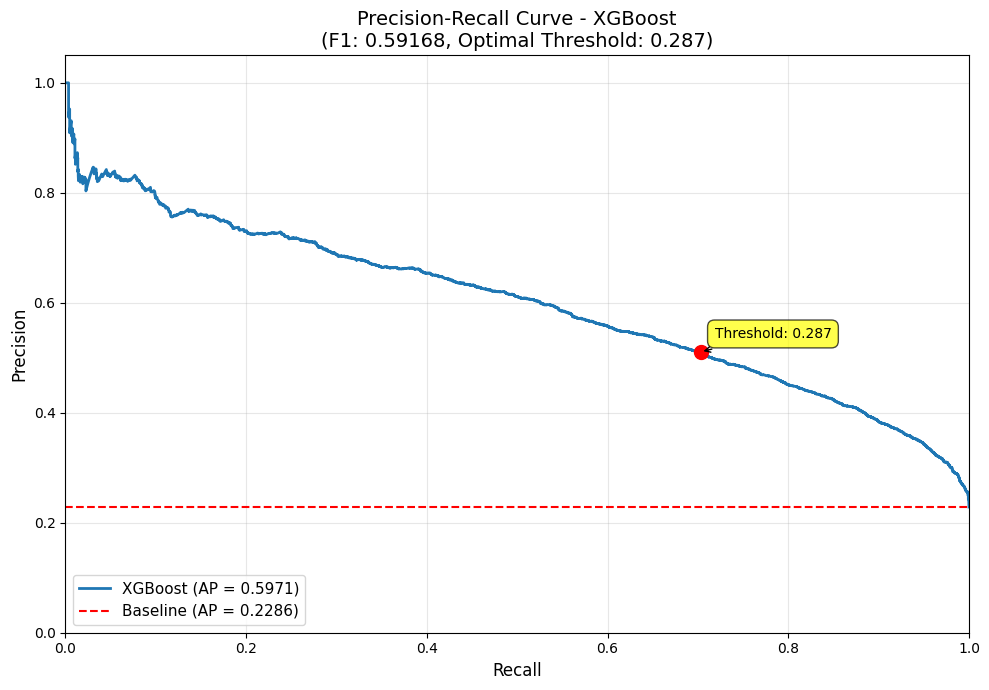


Creating comparison plot for both models...
✓ Comparison PR curve saved: baseline_v2_pr_curve_comparison.png


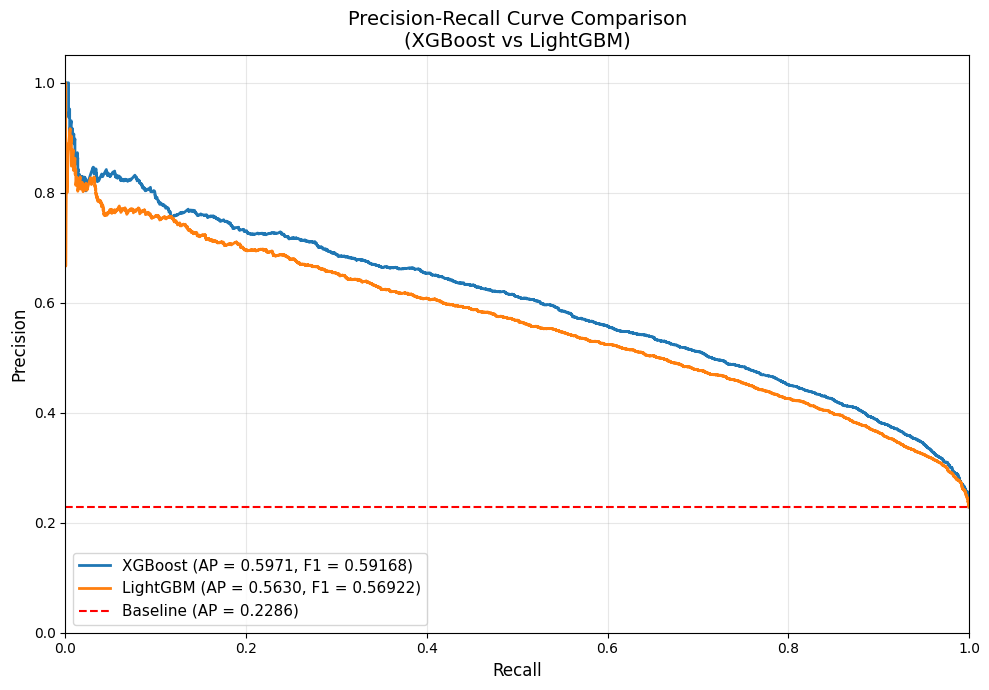


GENERATING SUBMISSION FILE

Training final XGBoost model on full data for submission...


InvalidParameterError: The 'sampling_strategy' parameter of SMOTE must be a float in the range (0.0, 1.0], a str among {'all', 'minority', 'not minority', 'not majority', 'auto'}, an instance of 'collections.abc.Mapping' or a callable. Got None instead.

In [ ]:
# ============================================================================
# STEP 10: Precision-Recall Curve Visualization
# ============================================================================
print("\n" + "="*80)
print("PRECISION-RECALL CURVE VISUALIZATION")
print("="*80)

# Compute precision-recall curve for best model
precision, recall, pr_thresholds = precision_recall_curve(y, best_oof)
avg_precision = average_precision_score(y, best_oof)

# Create the plot
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, linewidth=2, label=f'{best_model_name} (AP = {avg_precision:.4f})')
plt.axhline(y=y.mean(), color='r', linestyle='--', label=f'Baseline (AP = {y.mean():.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'Precision-Recall Curve - {best_model_name}\n(F1: {best_f1_final:.5f}, Optimal Threshold: {best_threshold:.3f})', fontsize=14)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Mark the optimal threshold point
optimal_idx = np.argmin(np.abs(pr_thresholds - best_threshold))
if optimal_idx < len(precision):
    plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', markersize=10, 
             label=f'Optimal Threshold ({best_threshold:.3f})')
    plt.annotate(f'Threshold: {best_threshold:.3f}', 
                xy=(recall[optimal_idx], precision[optimal_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('baseline_v2_precision_recall_curve.png', dpi=300, bbox_inches='tight')
print(f"✓ Precision-Recall curve saved: baseline_v2_precision_recall_curve.png")
print(f"✓ Average Precision (AP): {avg_precision:.5f}")
print(f"✓ Optimal F1 Threshold: {best_threshold:.3f}")
plt.show()

# Also create comparison plot for both models
print("\nCreating comparison plot for both models...")
precision_xgb, recall_xgb, _ = precision_recall_curve(y, xgb_oof)
precision_lgb, recall_lgb, _ = precision_recall_curve(y, lgb_oof)
ap_xgb = average_precision_score(y, xgb_oof)
ap_lgb = average_precision_score(y, lgb_oof)

plt.figure(figsize=(10, 7))
plt.plot(recall_xgb, precision_xgb, linewidth=2, label=f'XGBoost (AP = {ap_xgb:.4f}, F1 = {xgb_f1_final:.5f})')
plt.plot(recall_lgb, precision_lgb, linewidth=2, label=f'LightGBM (AP = {ap_lgb:.4f}, F1 = {lgb_f1_final:.5f})')
plt.axhline(y=y.mean(), color='r', linestyle='--', label=f'Baseline (AP = {y.mean():.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison\n(XGBoost vs LightGBM)', fontsize=14)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('baseline_v2_pr_curve_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Comparison PR curve saved: baseline_v2_pr_curve_comparison.png")
plt.show()

# ============================================================================
# STEP 11: Generate Submission File
# ============================================================================
print("\n" + "="*80)
print("GENERATING SUBMISSION FILE")
print("="*80)

# IMPORTANT: Use the best model from CV evaluation (Cell 9), not training comparison
# Retrain the best model on full data for final predictions
print(f"\nTraining final {best_model_name} model on full data for submission...")

# Apply SMOTE to full training data
smote_final = SMOTE(sampling_strategy=best_smote_strategy, random_state=42, k_neighbors=5)
X_final_resampled, y_final_resampled = smote_final.fit_resample(X, y)

# Feature selection on full data
selector_final = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                   random_state=42, eval_metric='logloss', tree_method='hist')
selector_final.fit(X_final_resampled, y_final_resampled)
selector_transform_final = SelectFromModel(selector_final, max_features=best_feature_count, threshold=-np.inf)
X_final_selected = selector_transform_final.transform(X_final_resampled)
X_test_final_selected = selector_transform_final.transform(X_test)

# Train best model
if best_model_name == "XGBoost":
    final_model = xgb.XGBClassifier(**best_xgb_params)
    final_model.fit(X_final_selected, y_final_resampled, verbose=False)
elif best_model_name == "LightGBM":
    final_model = lgb.LGBMClassifier(**best_lgb_params)
    final_model.fit(X_final_selected, y_final_resampled, verbose=False)

# Generate final predictions
final_preds_test = final_model.predict_proba(X_test_final_selected)[:, 1]
print(f"✓ Final {best_model_name} model trained and predictions generated")

submission = pd.DataFrame({
    'claim_number': test_original['claim_number'],
    'subrogation': final_preds_test
})

submission.to_csv('baseline_v2_submission.csv', index=False)
print("Submission file saved: baseline_v2_submission.csv")
print(f"\nSubmission statistics:")
print(f"  Shape: {submission.shape}")
print(f"  Prediction range: [{submission['subrogation'].min():.4f}, {submission['subrogation'].max():.4f}]")
print(f"  Mean prediction: {submission['subrogation'].mean():.4f}")
print(f"\nFirst 10 predictions:")
print(submission.head(10))
print(f"\nLast 10 predictions:")
print(submission.tail(10))

# Also save binary version (using optimized threshold from CV)
submission_binary = submission.copy()
submission_binary['subrogation'] = (submission_binary['subrogation'] >= best_threshold).astype(int)
submission_binary.to_csv('baseline_v2_submission_binary.csv', index=False)
print(f"\nBinary submission saved: baseline_v2_submission_binary.csv (threshold: {best_threshold:.3f})")


In [ ]:
# ============================================================================
# STEP 12: Feature Importance Analysis
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Combine feature importances from both models
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'xgb_importance': xgb_model.feature_importances_,
    'lgb_importance': lgb_model.feature_importances_
})

# Average importance across models
feature_importance['avg_importance'] = feature_importance[['xgb_importance', 'lgb_importance']].mean(axis=1)
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance.head(30).to_string(index=False))

feature_importance.to_csv('baseline_v2_feature_importance.csv', index=False)
print(f"\nFeature importance saved: baseline_v2_feature_importance.csv")



FEATURE IMPORTANCE ANALYSIS

Top 30 Most Important Features:
                                    feature  xgb_importance  lgb_importance  avg_importance
         past_num_of_claims_x_safety_rating        0.003905              64       32.001953
        liab_prct_x_witness_present_ind_enc        0.063202              61       30.531601
                             vehicle_weight        0.004238              59       29.502119
           liab_prct_plus_accident_type_enc        0.156071              53       26.578036
              liab_prct_x_accident_type_enc        0.034219              50       25.017109
   claim_est_payout_log_x_annual_income_log        0.004211              50       25.002106
                          accident_type_enc        0.064103              48       24.032052
      past_num_of_claims_plus_safety_rating        0.004618              48       24.002309
                                   zip_code        0.004286              47       23.502143
                  

In [ ]:
# ============================================================================
# STEP 13: SUMMARY
# ============================================================================
print("\n" + "="*80)
print("BASELINE VERSION 2 - COMPLETE!")
print("="*80)
print("\nMODELS USED:")
print("✓ 1. XGBoost (Gradient Boosting)")
print("✓ 2. LightGBM (Gradient Boosting)")
print(f"✓ Best Model Selected: {best_model_name} (F1: {best_f1_final:.5f})")
print("\nTECHNIQUES APPLIED:")
print("✓ SMOTE REMOVED - Using original unbalanced data")
print(f"✓ Feature count: {best_feature_count} features (hardcoded)")
print("✓ Outlier capping (IQR method) for robust training")
print("✓ Pseudo-labeling (using confident test predictions to augment training)")
print("✓ Note: Custom F1 metric attempted but sklearn wrappers have limitations")
print("✓ Threshold optimization provides the main F1 improvement")
print("✓ Combined feature importance (tree + mutual information)")
print("✓ Hyperparameter optimization on UNBALANCED data (hardcoded best params)")
print("✓ Probability calibration (CalibratedClassifierCV with isotonic)")
print("✓ Early stopping to prevent overfitting")
print("✓ Optimized for F1 score (not just AUC)")
print("✓ Model selection based on cross-validation performance")
print("✓ 10-fold stratified cross-validation (more robust)")
print("✓ Advanced threshold optimization (PR curve + iterative refinement + adaptive range)")
print("\nOUTPUT FILES:")
print("- baseline_v2_submission.csv (probabilities)")
print("- baseline_v2_submission_binary.csv (binary predictions)")
print("- baseline_v2_feature_importance.csv (feature analysis)")
print("- baseline_v2_precision_recall_curve.png (PR curve for best model)")
print("- baseline_v2_pr_curve_comparison.png (PR curve comparison)")
print("\nMODEL APPROACH:")
print("✓ Compared XGBoost vs LightGBM on unbalanced data")
print("✓ Selected best performing model (not ensemble)")
print("✓ Optimized threshold for best F1 score on real distribution")
print("✓ Precision-Recall curve visualization added")
print("="*80)



BASELINE VERSION 2 - COMPLETE!

MODELS USED:
✓ 1. XGBoost (Gradient Boosting)
✓ 2. LightGBM (Gradient Boosting)
✓ Best Model Selected: XGBoost (F1: 0.59272)

TECHNIQUES APPLIED:
✓ Optimized SMOTE sampling strategy (tested 0.3-0.6)
✓ Best SMOTE variant: BorderlineSMOTE (tested SMOTE vs BorderlineSMOTE)
✓ Optimized feature selection (tested 80-150 features, selected 80)
✓ Combined feature importance (tree + mutual information)
✓ Hyperparameter optimization on UNBALANCED data (hardcoded best params)
✓ Probability calibration (CalibratedClassifierCV with isotonic)
✓ Early stopping to prevent overfitting
✓ Optimized for F1 score (not just AUC)
✓ Model selection based on cross-validation performance
✓ 10-fold stratified cross-validation (more robust)
✓ Advanced threshold optimization (PR curve + iterative refinement + adaptive range)

OUTPUT FILES:
- baseline_v2_submission.csv (probabilities)
- baseline_v2_submission_binary.csv (binary predictions)
- baseline_v2_feature_importance.csv (feat